In [1]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
drive  sample_data


In [2]:
# move into project directory
repo_name = "Image-Colorization"
%cd /content/drive/MyDrive/Personal-Projects/$repo_name
!ls

/content/drive/MyDrive/Personal-Projects/Image-Colorization
common	     dataloading  Index.ipynb  output		     README.md	       transforms
config.yaml  experiments  index.py     preprocess	     requirements.txt  visualization
data	     Index_bc.py  models       project-structure.md  run.yaml


In [3]:
# set up environment
# comment out if not required
'''
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install matplotlib numpy pandas pyyaml opencv-python
'''

'\n!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118\n!pip install matplotlib numpy pandas pyyaml opencv-python\n'

In [4]:
# this cell is for downloading data.
# as of yet data is not hosted and is available in the private data folder


In [5]:
# setup some imports
#custom imports
from transforms.transforms import ToTensor
from dataloading.datareader import DataReader
from dataloading.dataset import CustomDataset
from common.utils import get_exp_params, init_config, get_config, save2config, get_saved_model, get_modelinfo, get_model_data
from models.unet import UNet
from models.custom_models import get_model

#py imports
import random
import numpy as np
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from experiments.experiments import Experiment
from visualization.visualization import Visualization
from experiments.test_model import ModelTester

In [6]:
# initialize directories and config data
init_config()
config = get_config()
print('Config parameters\n')
print(config)

Config parameters

{'X_key': 'L', 'data_dir': '/content/drive/MyDrive/Personal-Projects/Image-Colorization/data', 'device': 'cuda', 'output_dir': '/content/drive/MyDrive/Personal-Projects/Image-Colorization/output', 'root_dir': '/content/drive/MyDrive/Personal-Projects/Image-Colorization', 'use_gpu': True, 'y_key': 'AB'}


In [7]:
# read experiment parameters
exp_params = get_exp_params()
print('Experiment parameters\n')
print(exp_params)

Experiment parameters

{'transform': {'resize_dim': 256, 'crop_dim': 224}, 'train': {'shuffle_data': True, 'batch_size': 128, 'val_split_method': 'fixed-split', 'k': 3, 'val_percentage': 20, 'loss': 'mse', 'batch_interval': 512, 'epoch_interval': 50, 'num_epochs': 5000}, 'model': {'name': 'unet', 'optimizer': 'Adam', 'lr': 0.0001, 'weight_decay': 1e-07, 'amsgrad': True, 'momentum': 0.85}, 'test_model': False}


In [8]:
#initialize randomness seed
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [9]:
#save X_key and y_key
save2config('X_key', 'L')
save2config('y_key', 'AB')

#preprocess data or load preprocessed data
dr = DataReader()
ds = dr.get_split_data()
Ltr, ABtr, ftr_len = ds['Ltr'], ds['ABtr'], ds['ftr_len']
Lte, ABte, te_len = ds['Lte'], ds['ABte'], ds['te_len']
print('Shape of X and y:', ds['Ltr'].shape, ds['ABtr'].shape)

#transform data
composed_transforms =  transforms.Compose([
    ToTensor()
])
#convert to dataset
ftr_dataset = CustomDataset(Ltr, ABtr, ftr_len)
te_dataset = CustomDataset(Lte, ABte, te_len)
smlen = int(0.01 * len(ftr_dataset))
smftr_dataset = torch.utils.data.Subset(ftr_dataset, list(range(smlen)))
smftrte_dataset = torch.utils.data.Subset(ftr_dataset, list(range(10)))
smtelen = int(0.1 * len(te_dataset))
smfte_dataset = torch.utils.data.Subset(te_dataset, list(range(smtelen)))
print('Full train dataset length:', len(ftr_dataset))
print('Test dataset length:', len(te_dataset))
print('Subset train dataset length:', smlen)
print('Subset test dataset length:', smtelen, '\n')


Shape of X and y: (50000, 1, 32, 32) (50000, 2, 32, 32)
Full train dataset length: 50000
Test dataset length: 10
Subset train dataset length: 500
Subset test dataset length: 1 



In [10]:
#model training with small dataset

exp = Experiment(exp_params["model"]["name"], smftr_dataset)
model_history = exp.train()

Running straight split
	Running Epoch 50


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 63.14it/s]

	Epoch 49 Training Loss: 0.03244340181350708
	Epoch 49 Validation Loss: 0.03288016840815544
	Epoch 49 Validation Accuracy: 0.0



	Running Epoch 100


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 64.82it/s]

	Epoch 99 Training Loss: 0.019513621032238006
	Epoch 99 Validation Loss: 0.019526610150933266
	Epoch 99 Validation Accuracy: 0.0



	Running Epoch 150


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 43.83it/s]

	Epoch 149 Training Loss: 0.01740166563540697
	Epoch 149 Validation Loss: 0.017262237146496773
	Epoch 149 Validation Accuracy: 0.0



	Running Epoch 200


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 66.37it/s]

	Epoch 199 Training Loss: 0.01644458282738924
	Epoch 199 Validation Loss: 0.016083823516964912
	Epoch 199 Validation Accuracy: 0.0



	Running Epoch 250


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 67.65it/s]

	Epoch 249 Training Loss: 0.015776176750659943
	Epoch 249 Validation Loss: 0.015458837151527405
	Epoch 249 Validation Accuracy: 0.0



	Running Epoch 300


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 70.68it/s]

	Epoch 299 Training Loss: 0.015596285462379456
	Epoch 299 Validation Loss: 0.015299942344427109
	Epoch 299 Validation Accuracy: 0.0



	Running Epoch 350


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 67.07it/s]

	Epoch 349 Training Loss: 0.01515859991312027
	Epoch 349 Validation Loss: 0.01512464415282011
	Epoch 349 Validation Accuracy: 0.0



	Running Epoch 400


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 69.94it/s]

	Epoch 399 Training Loss: 0.014615496173501014
	Epoch 399 Validation Loss: 0.015198999084532261
	Epoch 399 Validation Accuracy: 0.0



	Running Epoch 450


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 73.11it/s]

	Epoch 449 Training Loss: 0.014361383765935898
	Epoch 449 Validation Loss: 0.01493790838867426
	Epoch 449 Validation Accuracy: 0.0



	Running Epoch 500


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 65.59it/s]

	Epoch 499 Training Loss: 0.013811172693967819
	Epoch 499 Validation Loss: 0.015115906484425068
	Epoch 499 Validation Accuracy: 0.0



	Running Epoch 550


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 68.13it/s]

	Epoch 549 Training Loss: 0.0134115344658494
	Epoch 549 Validation Loss: 0.01567496731877327
	Epoch 549 Validation Accuracy: 0.0



	Running Epoch 600


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 68.55it/s]

	Epoch 599 Training Loss: 0.01306221418082714
	Epoch 599 Validation Loss: 0.015089609660208225
	Epoch 599 Validation Accuracy: 0.0



	Running Epoch 650


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 61.37it/s]

	Epoch 649 Training Loss: 0.012288201972842217
	Epoch 649 Validation Loss: 0.015241162851452827
	Epoch 649 Validation Accuracy: 0.0



	Running Epoch 700


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 64.57it/s]

	Epoch 699 Training Loss: 0.012065322101116181
	Epoch 699 Validation Loss: 0.015872597694396973
	Epoch 699 Validation Accuracy: 0.0



	Running Epoch 750


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 51.98it/s]

	Epoch 749 Training Loss: 0.011551546379923821
	Epoch 749 Validation Loss: 0.0162286926060915
	Epoch 749 Validation Accuracy: 0.0



	Running Epoch 800


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 65.80it/s]

	Epoch 799 Training Loss: 0.01116137683391571
	Epoch 799 Validation Loss: 0.015847694128751755
	Epoch 799 Validation Accuracy: 0.0



	Running Epoch 850


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 68.82it/s]

	Epoch 849 Training Loss: 0.010925214737653732
	Epoch 849 Validation Loss: 0.016178233548998833
	Epoch 849 Validation Accuracy: 0.0



	Running Epoch 900


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 65.00it/s]

	Epoch 899 Training Loss: 0.010555127039551734
	Epoch 899 Validation Loss: 0.015954507514834404
	Epoch 899 Validation Accuracy: 0.0



	Running Epoch 950


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 58.08it/s]

	Epoch 949 Training Loss: 0.010206127353012562
	Epoch 949 Validation Loss: 0.016239061951637268
	Epoch 949 Validation Accuracy: 0.0



	Running Epoch 1000


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 68.55it/s]

	Epoch 999 Training Loss: 0.010107382908463478
	Epoch 999 Validation Loss: 0.017260754480957985
	Epoch 999 Validation Accuracy: 0.0



	Running Epoch 1050


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 68.56it/s]

	Epoch 1049 Training Loss: 0.009887866526842117
	Epoch 1049 Validation Loss: 0.015932025387883186
	Epoch 1049 Validation Accuracy: 0.0



	Running Epoch 1100


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 65.08it/s]

	Epoch 1099 Training Loss: 0.009739734046161175
	Epoch 1099 Validation Loss: 0.0163568127900362
	Epoch 1099 Validation Accuracy: 0.0



	Running Epoch 1150


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 16.02it/s]


	Epoch 1149 Training Loss: 0.00937740370631218
	Epoch 1149 Validation Loss: 0.016735179349780083
	Epoch 1149 Validation Accuracy: 0.0

	Running Epoch 1200


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 65.32it/s]

	Epoch 1199 Training Loss: 0.009599435403943061
	Epoch 1199 Validation Loss: 0.016456138342618942
	Epoch 1199 Validation Accuracy: 0.0



	Running Epoch 1250


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 50.88it/s]

	Epoch 1249 Training Loss: 0.009364624470472337
	Epoch 1249 Validation Loss: 0.016309291124343872
	Epoch 1249 Validation Accuracy: 0.0



	Running Epoch 1300


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 69.74it/s]

	Epoch 1299 Training Loss: 0.009155690744519234
	Epoch 1299 Validation Loss: 0.015496880747377872
	Epoch 1299 Validation Accuracy: 0.0



	Running Epoch 1350


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 64.17it/s]

	Epoch 1349 Training Loss: 0.008995894566178322
	Epoch 1349 Validation Loss: 0.016070418059825897
	Epoch 1349 Validation Accuracy: 0.0



	Running Epoch 1400


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 66.36it/s]

	Epoch 1399 Training Loss: 0.008820693902671338
	Epoch 1399 Validation Loss: 0.015814749523997307
	Epoch 1399 Validation Accuracy: 0.0



	Running Epoch 1450


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 57.41it/s]

	Epoch 1449 Training Loss: 0.008694871962070465
	Epoch 1449 Validation Loss: 0.016237884759902954
	Epoch 1449 Validation Accuracy: 0.0



	Running Epoch 1500


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 65.84it/s]

	Epoch 1499 Training Loss: 0.00860790368169546
	Epoch 1499 Validation Loss: 0.015462236478924751
	Epoch 1499 Validation Accuracy: 0.0



	Running Epoch 1550


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 57.69it/s]

	Epoch 1549 Training Loss: 0.008528581149876117
	Epoch 1549 Validation Loss: 0.015739621594548225
	Epoch 1549 Validation Accuracy: 0.0



	Running Epoch 1600


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 61.78it/s]

	Epoch 1599 Training Loss: 0.008478884287178516
	Epoch 1599 Validation Loss: 0.015908874571323395
	Epoch 1599 Validation Accuracy: 0.0



	Running Epoch 1650


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 65.60it/s]

	Epoch 1649 Training Loss: 0.008531105816364288
	Epoch 1649 Validation Loss: 0.01655726134777069
	Epoch 1649 Validation Accuracy: 0.0



	Running Epoch 1700


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 65.38it/s]

	Epoch 1699 Training Loss: 0.008265691809356213
	Epoch 1699 Validation Loss: 0.016120046377182007
	Epoch 1699 Validation Accuracy: 0.0



	Running Epoch 1750


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 66.00it/s]

	Epoch 1749 Training Loss: 0.008192360550165177
	Epoch 1749 Validation Loss: 0.016208022832870483
	Epoch 1749 Validation Accuracy: 0.0



	Running Epoch 1800


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 58.19it/s]

	Epoch 1799 Training Loss: 0.008407927751541137
	Epoch 1799 Validation Loss: 0.016521606594324112
	Epoch 1799 Validation Accuracy: 0.0



	Running Epoch 1850


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 61.46it/s]

	Epoch 1849 Training Loss: 0.008215941842645407
	Epoch 1849 Validation Loss: 0.016201378777623177
	Epoch 1849 Validation Accuracy: 0.0



	Running Epoch 1900


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 54.69it/s]

	Epoch 1899 Training Loss: 0.008310197442770005
	Epoch 1899 Validation Loss: 0.016466431319713593
	Epoch 1899 Validation Accuracy: 0.0



	Running Epoch 1950


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 51.35it/s]

	Epoch 1949 Training Loss: 0.008126983232796193
	Epoch 1949 Validation Loss: 0.01641353778541088
	Epoch 1949 Validation Accuracy: 0.0



	Running Epoch 2000


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 65.45it/s]

	Epoch 1999 Training Loss: 0.00796721488237381
	Epoch 1999 Validation Loss: 0.015772201120853424
	Epoch 1999 Validation Accuracy: 0.0



	Running Epoch 2050


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 69.13it/s]

	Epoch 2049 Training Loss: 0.007804786264896393
	Epoch 2049 Validation Loss: 0.016111766919493675
	Epoch 2049 Validation Accuracy: 0.0



	Running Epoch 2100


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 58.09it/s]

	Epoch 2099 Training Loss: 0.00793724574148655
	Epoch 2099 Validation Loss: 0.016148807480931282
	Epoch 2099 Validation Accuracy: 0.0



	Running Epoch 2150


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 61.84it/s]

	Epoch 2149 Training Loss: 0.007873535081744194
	Epoch 2149 Validation Loss: 0.016657201573252678
	Epoch 2149 Validation Accuracy: 0.0



	Running Epoch 2200


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 65.40it/s]

	Epoch 2199 Training Loss: 0.0077284064143896105
	Epoch 2199 Validation Loss: 0.015895310789346695
	Epoch 2199 Validation Accuracy: 0.0



	Running Epoch 2250


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 64.22it/s]

	Epoch 2249 Training Loss: 0.007799691371619701
	Epoch 2249 Validation Loss: 0.016241490840911865
	Epoch 2249 Validation Accuracy: 0.0



	Running Epoch 2300


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 46.63it/s]

	Epoch 2299 Training Loss: 0.007649698406457901
	Epoch 2299 Validation Loss: 0.015792109072208405
	Epoch 2299 Validation Accuracy: 0.0



	Running Epoch 2350


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 64.12it/s]

	Epoch 2349 Training Loss: 0.007764398530125618
	Epoch 2349 Validation Loss: 0.01617257669568062
	Epoch 2349 Validation Accuracy: 0.0



	Running Epoch 2400


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 58.18it/s]

	Epoch 2399 Training Loss: 0.007663683407008648
	Epoch 2399 Validation Loss: 0.016571981832385063
	Epoch 2399 Validation Accuracy: 0.0



	Running Epoch 2450


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 59.53it/s]

	Epoch 2449 Training Loss: 0.0075024722516536715
	Epoch 2449 Validation Loss: 0.016319358721375465
	Epoch 2449 Validation Accuracy: 0.0



	Running Epoch 2500


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 66.33it/s]

	Epoch 2499 Training Loss: 0.007567189745604992
	Epoch 2499 Validation Loss: 0.016182847321033478
	Epoch 2499 Validation Accuracy: 0.0



	Running Epoch 2550


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 69.70it/s]

	Epoch 2549 Training Loss: 0.007411822490394115
	Epoch 2549 Validation Loss: 0.01629509963095188
	Epoch 2549 Validation Accuracy: 0.0



	Running Epoch 2600


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 55.73it/s]

	Epoch 2599 Training Loss: 0.0076570560038089755
	Epoch 2599 Validation Loss: 0.016339799389243126
	Epoch 2599 Validation Accuracy: 0.0



	Running Epoch 2650


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 62.82it/s]

	Epoch 2649 Training Loss: 0.007417850866913795
	Epoch 2649 Validation Loss: 0.015812039375305176
	Epoch 2649 Validation Accuracy: 0.0



	Running Epoch 2700


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 66.69it/s]

	Epoch 2699 Training Loss: 0.0075812251307070255
	Epoch 2699 Validation Loss: 0.016288423910737038
	Epoch 2699 Validation Accuracy: 0.0



	Running Epoch 2750


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 47.85it/s]

	Epoch 2749 Training Loss: 0.007423193380236626
	Epoch 2749 Validation Loss: 0.016137396916747093
	Epoch 2749 Validation Accuracy: 0.0



	Running Epoch 2800


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 42.80it/s]

	Epoch 2799 Training Loss: 0.007650862485170364
	Epoch 2799 Validation Loss: 0.01688242144882679
	Epoch 2799 Validation Accuracy: 0.0



	Running Epoch 2850


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 66.81it/s]

	Epoch 2849 Training Loss: 0.007670841813087463
	Epoch 2849 Validation Loss: 0.01591881550848484
	Epoch 2849 Validation Accuracy: 0.0



	Running Epoch 2900


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 65.10it/s]

	Epoch 2899 Training Loss: 0.0073184285871684554
	Epoch 2899 Validation Loss: 0.01611514203250408
	Epoch 2899 Validation Accuracy: 0.0



	Running Epoch 2950


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 55.36it/s]

	Epoch 2949 Training Loss: 0.007407083213329315
	Epoch 2949 Validation Loss: 0.015813643112778664
	Epoch 2949 Validation Accuracy: 0.0



	Running Epoch 3000


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 65.94it/s]

	Epoch 2999 Training Loss: 0.0072176485136151314
	Epoch 2999 Validation Loss: 0.016552872955799103
	Epoch 2999 Validation Accuracy: 0.0



	Running Epoch 3050


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 63.37it/s]

	Epoch 3049 Training Loss: 0.007419094201177359
	Epoch 3049 Validation Loss: 0.016180582344532013
	Epoch 3049 Validation Accuracy: 0.0



	Running Epoch 3100


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 68.37it/s]

	Epoch 3099 Training Loss: 0.00715019853785634
	Epoch 3099 Validation Loss: 0.016021275892853737
	Epoch 3099 Validation Accuracy: 0.0



	Running Epoch 3150


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 49.70it/s]

	Epoch 3149 Training Loss: 0.007356252111494541
	Epoch 3149 Validation Loss: 0.01640802063047886
	Epoch 3149 Validation Accuracy: 0.0



	Running Epoch 3200


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 68.01it/s]

	Epoch 3199 Training Loss: 0.007166284397244454
	Epoch 3199 Validation Loss: 0.016060421243309975
	Epoch 3199 Validation Accuracy: 0.0



	Running Epoch 3250


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 67.62it/s]

	Epoch 3249 Training Loss: 0.007126950398087501
	Epoch 3249 Validation Loss: 0.016347186639904976
	Epoch 3249 Validation Accuracy: 0.0



	Running Epoch 3300


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 51.97it/s]

	Epoch 3299 Training Loss: 0.007239055614918471
	Epoch 3299 Validation Loss: 0.01700475811958313
	Epoch 3299 Validation Accuracy: 0.0



	Running Epoch 3350


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 52.29it/s]

	Epoch 3349 Training Loss: 0.0070585448294878
	Epoch 3349 Validation Loss: 0.016034189611673355
	Epoch 3349 Validation Accuracy: 0.0



	Running Epoch 3400


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 64.90it/s]

	Epoch 3399 Training Loss: 0.007070442214608192
	Epoch 3399 Validation Loss: 0.015970492735505104
	Epoch 3399 Validation Accuracy: 0.0



	Running Epoch 3450


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 48.98it/s]

	Epoch 3449 Training Loss: 0.007075983956456184
	Epoch 3449 Validation Loss: 0.016205063089728355
	Epoch 3449 Validation Accuracy: 0.0



	Running Epoch 3500


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 47.43it/s]

	Epoch 3499 Training Loss: 0.0070056053064763545
	Epoch 3499 Validation Loss: 0.01626056246459484
	Epoch 3499 Validation Accuracy: 0.0



	Running Epoch 3550


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 54.14it/s]

	Epoch 3549 Training Loss: 0.007119962461292744
	Epoch 3549 Validation Loss: 0.016476230695843697
	Epoch 3549 Validation Accuracy: 0.0



	Running Epoch 3600


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 41.56it/s]

	Epoch 3599 Training Loss: 0.006988908015191555
	Epoch 3599 Validation Loss: 0.015837520360946655
	Epoch 3599 Validation Accuracy: 0.0



	Running Epoch 3650


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 58.19it/s]

	Epoch 3649 Training Loss: 0.006873905062675476
	Epoch 3649 Validation Loss: 0.01618274860084057
	Epoch 3649 Validation Accuracy: 0.0



	Running Epoch 3700


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 59.90it/s]

	Epoch 3699 Training Loss: 0.0070707713812589645
	Epoch 3699 Validation Loss: 0.01661805249750614
	Epoch 3699 Validation Accuracy: 0.0



	Running Epoch 3750


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 54.19it/s]

	Epoch 3749 Training Loss: 0.006975525729358196
	Epoch 3749 Validation Loss: 0.016269922256469727
	Epoch 3749 Validation Accuracy: 0.0



	Running Epoch 3800


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 63.52it/s]

	Epoch 3799 Training Loss: 0.006888133101165294
	Epoch 3799 Validation Loss: 0.01618048921227455
	Epoch 3799 Validation Accuracy: 0.0



	Running Epoch 3850


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 62.84it/s]

	Epoch 3849 Training Loss: 0.006906587556004524
	Epoch 3849 Validation Loss: 0.016640517860651016
	Epoch 3849 Validation Accuracy: 0.0



	Running Epoch 3900


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 58.87it/s]

	Epoch 3899 Training Loss: 0.006877963766455651
	Epoch 3899 Validation Loss: 0.016075290739536285
	Epoch 3899 Validation Accuracy: 0.0



	Running Epoch 3950


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 62.45it/s]

	Epoch 3949 Training Loss: 0.00691363874822855
	Epoch 3949 Validation Loss: 0.01620628498494625
	Epoch 3949 Validation Accuracy: 0.0



	Running Epoch 4000


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 60.69it/s]

	Epoch 3999 Training Loss: 0.0068961607106029985
	Epoch 3999 Validation Loss: 0.016293389722704887
	Epoch 3999 Validation Accuracy: 0.0



	Running Epoch 4050


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 59.12it/s]

	Epoch 4049 Training Loss: 0.006859868001192808
	Epoch 4049 Validation Loss: 0.01623629592359066
	Epoch 4049 Validation Accuracy: 0.0



	Running Epoch 4100


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 66.02it/s]

	Epoch 4099 Training Loss: 0.006794919762760401
	Epoch 4099 Validation Loss: 0.016490548849105835
	Epoch 4099 Validation Accuracy: 0.0



	Running Epoch 4150


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 65.84it/s]

	Epoch 4149 Training Loss: 0.006771828085184097
	Epoch 4149 Validation Loss: 0.016170313581824303
	Epoch 4149 Validation Accuracy: 0.0



	Running Epoch 4200


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 60.78it/s]

	Epoch 4199 Training Loss: 0.0072366265952587125
	Epoch 4199 Validation Loss: 0.016221100464463234
	Epoch 4199 Validation Accuracy: 0.0



	Running Epoch 4250


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 63.74it/s]

	Epoch 4249 Training Loss: 0.0067418661527335645
	Epoch 4249 Validation Loss: 0.015551911666989326
	Epoch 4249 Validation Accuracy: 0.0



	Running Epoch 4300


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 66.13it/s]

	Epoch 4299 Training Loss: 0.006766890250146389
	Epoch 4299 Validation Loss: 0.015918783843517303
	Epoch 4299 Validation Accuracy: 0.0



	Running Epoch 4350


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 54.90it/s]

	Epoch 4349 Training Loss: 0.006765131503343582
	Epoch 4349 Validation Loss: 0.016064872965216637
	Epoch 4349 Validation Accuracy: 0.0



	Running Epoch 4400


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 60.63it/s]

	Epoch 4399 Training Loss: 0.006689403560012579
	Epoch 4399 Validation Loss: 0.015747057273983955
	Epoch 4399 Validation Accuracy: 0.0



	Running Epoch 4450


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 60.41it/s]

	Epoch 4449 Training Loss: 0.0066866113990545276
	Epoch 4449 Validation Loss: 0.015849538147449493
	Epoch 4449 Validation Accuracy: 0.0



	Running Epoch 4500


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 62.84it/s]

	Epoch 4499 Training Loss: 0.00666870042681694
	Epoch 4499 Validation Loss: 0.01582890748977661
	Epoch 4499 Validation Accuracy: 0.0



	Running Epoch 4550


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 55.62it/s]

	Epoch 4549 Training Loss: 0.006592645607888699
	Epoch 4549 Validation Loss: 0.015855133533477783
	Epoch 4549 Validation Accuracy: 0.0



	Running Epoch 4600


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 60.39it/s]

	Epoch 4599 Training Loss: 0.006659131608903408
	Epoch 4599 Validation Loss: 0.015923188999295235
	Epoch 4599 Validation Accuracy: 0.0



	Running Epoch 4650


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 60.88it/s]

	Epoch 4649 Training Loss: 0.006780538335442543
	Epoch 4649 Validation Loss: 0.01623491756618023
	Epoch 4649 Validation Accuracy: 0.0



	Running Epoch 4700


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 66.47it/s]

	Epoch 4699 Training Loss: 0.006634743250906468
	Epoch 4699 Validation Loss: 0.01638542301952839
	Epoch 4699 Validation Accuracy: 0.0



	Running Epoch 4750


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 63.32it/s]

	Epoch 4749 Training Loss: 0.006584924310445785
	Epoch 4749 Validation Loss: 0.015858683735132217
	Epoch 4749 Validation Accuracy: 0.0



	Running Epoch 4800


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 58.45it/s]

	Epoch 4799 Training Loss: 0.00665815182030201
	Epoch 4799 Validation Loss: 0.015793543308973312
	Epoch 4799 Validation Accuracy: 0.0



	Running Epoch 4850


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 63.79it/s]

	Epoch 4849 Training Loss: 0.006561577692627907
	Epoch 4849 Validation Loss: 0.015458443202078342
	Epoch 4849 Validation Accuracy: 0.0



	Running Epoch 4900


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 60.70it/s]

	Epoch 4899 Training Loss: 0.006607034616172314
	Epoch 4899 Validation Loss: 0.016153790056705475
	Epoch 4899 Validation Accuracy: 0.0



	Running Epoch 4950


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 57.69it/s]

	Epoch 4949 Training Loss: 0.006555503364652395
	Epoch 4949 Validation Loss: 0.015997715294361115
	Epoch 4949 Validation Accuracy: 0.0



	Running Epoch 5000


		Running through validation set: 100%|██████████| 1/1 [00:00<00:00, 60.34it/s]

	Epoch 4999 Training Loss: 0.006640036180615425
	Epoch 4999 Validation Loss: 0.015576014295220375
	Epoch 4999 Validation Accuracy: 0.0



0.0

Model validation results

Model results




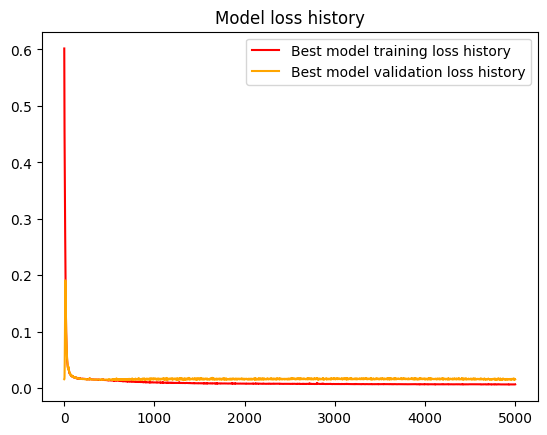

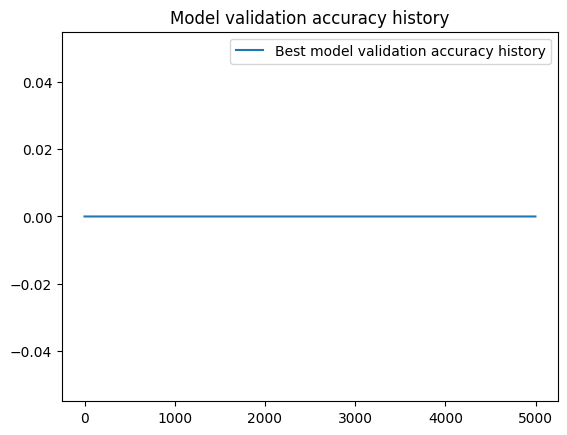


Model Training Loss: 0.006640036180615425
Model Validation Loss: 0.015576014295220375
Model Accuracy: 0.0



In [11]:
# get best model
model, model_history, _ = get_model_data(exp_params["model"]["name"])
#model = get_saved_model(model, '')
model_info = get_modelinfo('')
print(model_info['results']['valacchistory'][-3])
print("\nModel validation results")
#visualization results
vis = Visualization(model_info, model_history)
vis.get_results()


In [12]:
#script for testing the model

from common.utils import get_exp_params, get_accuracy, get_config, get_model_filename
from torch.utils.data import DataLoader
import torch
from matplotlib import pyplot as plt
from common import colorspaces

class ModelTester:

    def __init__(self, model, te_dataset):
        cfg = get_config()
        self.te_dataset = te_dataset
        self.model = model.cpu()
        self.model.eval()
        self.exp_params = get_exp_params()
        self.te_loader = DataLoader(self.te_dataset,
            batch_size = self.exp_params['train']['batch_size'],
            shuffle = False
        )
        self.output_dir = cfg['output_dir']
        self.X_key = cfg['X_key']
        self.y_key = cfg['y_key']

    def __loss_fn(self, loss_name = 'cross-entropy'):
        if loss_name == 'cross-entropy':
            return torch.nn.CrossEntropyLoss()
        elif loss_name == 'mse':
            return torch.nn.MSELoss()
        elif loss_name == 'l1':
            return torch.nn.L1Loss()
        else:
            raise SystemExit("Error: no valid loss function name passed! Check run.yaml")

    def __plot_predicted_images(self, L, AB_pred, RGB, AB):
        L = L.transpose(1, 3).transpose(1, 2)
        AB = torch.from_numpy(AB)
        AB = AB.transpose(1, 3).transpose(1, 2)
        AB_pred = AB_pred.transpose(1, 3).transpose(1, 2)
        pred_LAB = torch.concat((L[:, :, :, :], AB_pred.detach()), dim = 3)
        n = len(self.te_dataset)
        plt.clf()
        plt.figure(figsize=(n,7))
        for i in range(n):
            pos = i + 1
            #Plot true image
            plt.subplot(7,n,pos)
            plt.imshow(RGB[i,:,:,:])
            plt.axis(False)

            pos = i + n + 1
            #Plot L channel
            plt.subplot(7,n,pos)
            plt.imshow(L[i,:,:],cmap="gray")
            plt.axis(False)

            pos = i + (2 * n) + 1
            #Plot true A channel
            plt.subplot(7, n, pos)
            plt.imshow(AB[i,:,:, 0])
            plt.axis(False)

            pos = i + (3 * n) + 1
            #Plot predicted A channel
            plt.subplot(7,n,pos)
            plt.imshow(AB_pred[i,:,:,0].detach())
            plt.axis(False)

            pos = i + (4 * n) + 1
            #Plot true B channel
            plt.subplot(7, n, pos)
            plt.imshow(AB[i,:,:,1])
            plt.axis(False)

            pos = i + (5 * n) + 1
            #Plot predicted B channel
            plt.subplot(7,n,pos)
            plt.imshow(AB_pred[i,:,:,1].detach())
            plt.axis(False)

            pos = i + (6 * n) + 1
            #Convert LAB prediction to RGB and plot
            pred_RGB = colorspaces.lab_to_rgb(pred_LAB[i,:,:,:])
            plt.subplot(7,n,pos)
            plt.imshow(pred_RGB[0,:,:,:])
            plt.axis(False)

        plt.savefig(f'{self.output_dir}/test_results.png')
        plt.show()

    def test_and_plot(self, RGB, ABtrue, model_type = 'best_model', save_model_temporarily = False):
        loss_fn = self.__loss_fn(self.exp_params["train"]["loss"])
        running_loss = 0.0
        acc = 0
        for _, batch in enumerate(self.te_loader):
            op = self.model(batch[self.X_key])
            loss = loss_fn(op, batch[self.y_key])
            running_loss += loss.item()
            acc = get_accuracy(op, batch[self.y_key])
            self.__plot_predicted_images(batch[self.X_key], op, RGB, ABtrue)
        print("\nTest Loss:", running_loss/len(self.te_loader))
        print("Test Accuracy:", acc/len(self.te_loader), "\n")





Testing Saved Model


<Figure size 640x480 with 0 Axes>

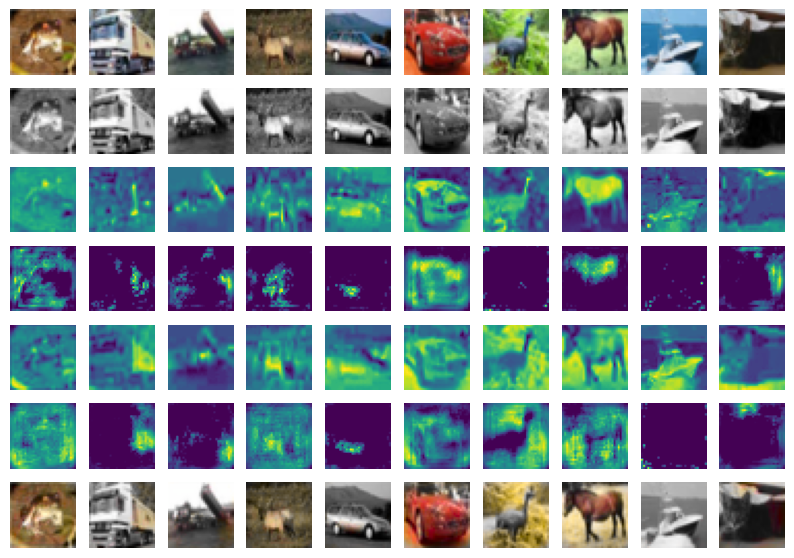


Test Loss: 0.010641607455909252
Test Accuracy: tensor(0.1000) 



In [13]:
#model testing with small subset of training dataset
model = get_model(exp_params["model"]["name"])
model.load_state_dict(torch.load("models/checkpoints/last_model.pt", map_location = torch.device(config["device"])))
print("\n\nTesting Saved Model")
mt = ModelTester(model, smftrte_dataset)
mt.test_and_plot(ds["RGBtr"], ABtr, "best_model", True)



Testing Saved Model


<Figure size 640x480 with 0 Axes>

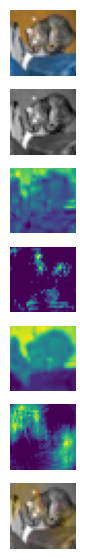


Test Loss: 0.02767026051878929
Test Accuracy: tensor(0.) 



In [14]:
#model testing with small test data
model = get_model(exp_params["model"]["name"])
model.load_state_dict(torch.load("models/checkpoints/last_model.pt", map_location = torch.device(config["device"])))
print("\n\nTesting Saved Model")
mt = ModelTester(model, smfte_dataset)
mt.test_and_plot(ds["RGBte"], ABte, "best_model", True)

In [15]:
'''
#model training with full dataset

exp = Experiment(exp_params["model"]["name"], ftr_dataset)
model_history = exp.train()
'''

'\n#model training with full dataset\n\nexp = Experiment(exp_params["model"]["name"], ftr_dataset)\nmodel_history = exp.train()\n'

In [16]:
'''
# get best model
model, model_history, _ = get_model_data(exp_params["model"]["name"])
#model = get_saved_model(model, '')
model_info = get_modelinfo('')

print("\nModel validation results")
#visualization results
vis = Visualization(model_info, model_history)
vis.get_results()
'''

'\n# get best model\nmodel, model_history, _ = get_model_data(exp_params["model"]["name"])\n#model = get_saved_model(model, \'\')\nmodel_info = get_modelinfo(\'\')\n\nprint("\nModel validation results")\n#visualization results\nvis = Visualization(model_info, model_history)\nvis.get_results()\n'

In [17]:
'''
#model testing
model = get_model(exp_params["model"]["name"])
model.load_state_dict(torch.load("models/checkpoints/last_model.pt", map_location = torch.device(config["device"])))
print("\n\nTesting Saved Model")
mt = ModelTester(model, te_dataset)
mt.test_and_plot(ds["RGBte"], "best_model", True)
'''

'\n#model testing\nmodel = get_model(exp_params["model"]["name"])\nmodel.load_state_dict(torch.load("models/checkpoints/last_model.pt", map_location = torch.device(config["device"])))\nprint("\n\nTesting Saved Model")\nmt = ModelTester(model, te_dataset)\nmt.test_and_plot(ds["RGBte"], "best_model", True)\n'